In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as col
%matplotlib inline

In [2]:
# font size and style
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

cm = 'rainbow'
s  = 50  # marker size

# plot settings
nrow = 2
ncol = 2

leglabels = ['$A_\mathrm{dendrite}$','$A_\mathrm{plates}$', 'fit', '$N_\mathrm{dendrite}$','$N_\mathrm{plates}$', \
             '$A_\mathrm{model}$', '$A_\mathrm{model, fit}$']
alabels = ['$D$ [m]', '$A$ [m$^{-2}$]', leglabels[1]+' / ' + leglabels[0], '$\\rho_\mathrm{app.}$', '$N$']

In [3]:
low_limit = 5e-6
up_limit= 1e-2
D_small = np.logspace(-6, -2, num=101)
rho_app = np.zeros(len(D_small))
rho_red = np.zeros(len(D_small))

In [4]:
# load data from prototype
path  ='../Prototype/output/'
file1 = path + 'T_range_-20-0_p1010.0_dt1.0_t_end600_r_start4e-06_mD_1.out'

var   = ['t', 'T', 'a', 'c', 'phi', 'm', 'V', 'vt']
tab1  = pd.read_csv(file1, delimiter = ',', names=var) 

In [5]:
rho_app_proto = tab1['m'] / tab1['V']

D_max = np.zeros(len(tab1['a']))
for idx, i in enumerate(rho_app_proto):
    D_max[idx] = 2. * max(tab1['a'][idx],tab1['c'][idx])

In [6]:
chi_snow = 0.
rhoi = 918.

# number of asperities per m² for the two different types
def A_dendrite(chi_snow, D):
    A_den = 1.41e6 * (1. + 100. * chi_snow**2) * (1. + (3.98e-5 / np.clip(D_small,5e-4,5e-3)**1.5))
    return A_den
def A_plate(chi_snow, D):
    A_pla = 1.58e7 * (1. + 100. * chi_snow**2) * (1. + (1.33e-4 / np.clip(D_small,5e-4,5e-3)**1.5))
    return A_pla
def N_frag(alpha, A, B, cke, gamma_snow):
    N_frag = alpha * A * ( 1. - np.exp(-( (B * cke) / (alpha * A) )**gamma_snow) )
    return N_frag
A_den = A_dendrite(chi_snow, D_small)
A_pla = A_plate(chi_snow, D_small)

In [87]:
# fit parameters
D_min = 100e-6
rho_min = 200.

# exemplary curves of A for an artificial reduction in rho_app with D
A_tot = np.zeros(len(D_small))
for idx, d in enumerate(D_small):
    if d <= D_min:
        rho_app[idx] = rhoi
        A_tot[idx] = A_pla[idx]
    else:
        rho_app[idx] = rhoi * (D_min / d ) + rho_min * (1 - (D_min / d) ) 
        rho_red[idx] = (rho_app[idx]-rho_min)
        A_tot[idx]   =  A_pla[idx] * ( rho_red[idx] / rhoi) + A_den[idx] * (1 - rho_red[idx] / rhoi )

#A_tot2 =  A_pla * (rho_app / rhoi) + A_den * (rho_min / rho_app) 

In [88]:
rho_red_proto = np.zeros(len(tab1['a']))
A_proto       = np.zeros(len(tab1['a']))
A_proto_norm  = np.zeros(len(tab1['a']))

# Calculate A for prototype values, with T-criterion and with the fit
A_d = A_dendrite(chi_snow, D_max)
A_p = A_plate(chi_snow, D_max)
for idx, d in enumerate(D_max):
    rho_red_proto[idx] = (rho_app_proto[idx]-rho_min)
    if tab1['T'][idx] > 256.15 and tab1['T'][idx] <= 261.15:
        A_proto_norm[idx] = A_d[idx]
    else:
        A_proto_norm[idx] = A_p[idx]
    if rho_app_proto[idx] > 0.95*rhoi:
        A_proto[idx] = A_p[idx]
    else:
        A_proto[idx] = A_p[idx] * ( rho_red_proto[idx] / rhoi) + A_d[idx] * (1 - rho_red_proto[idx] / rhoi )

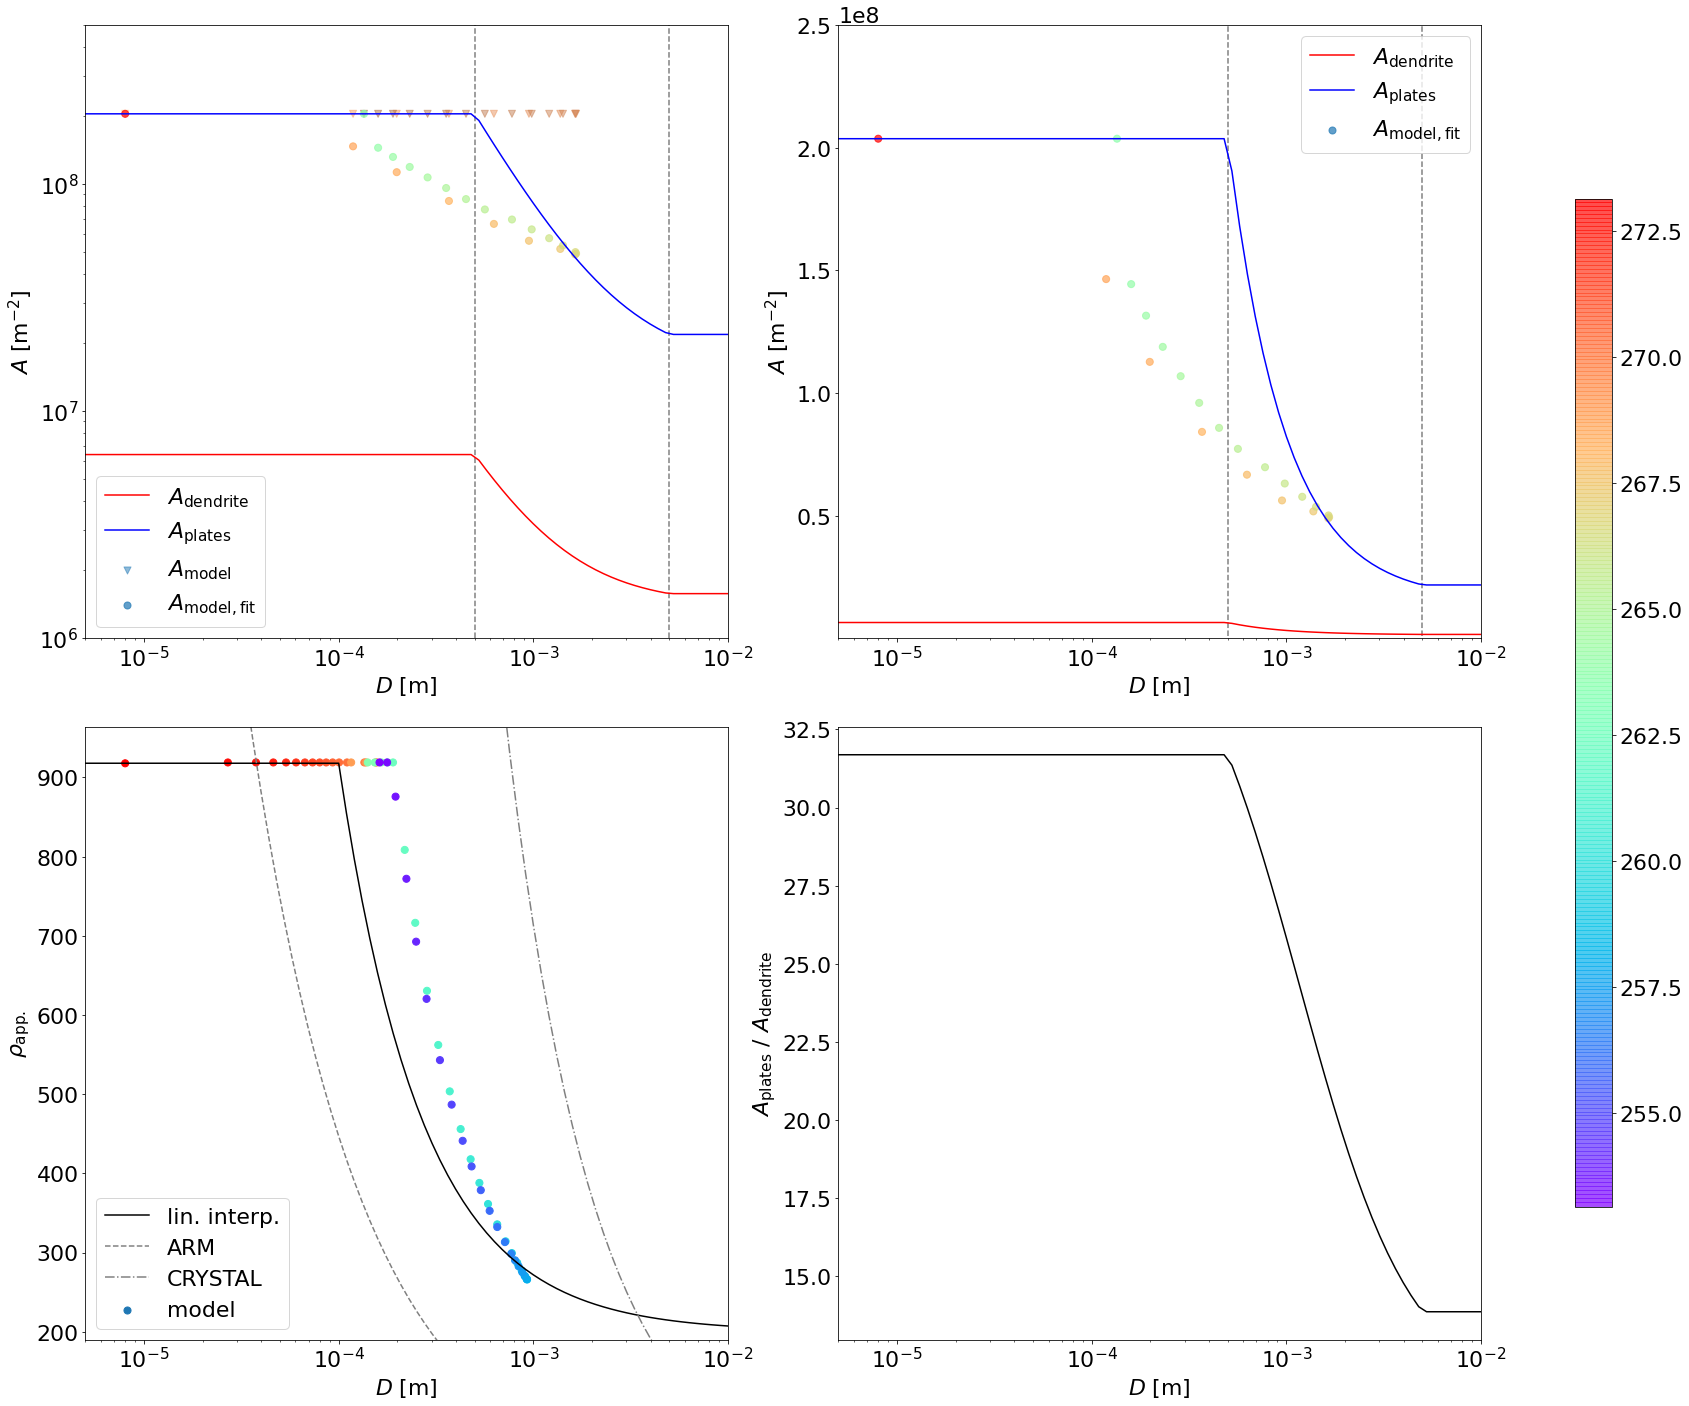

In [89]:
# plotting data
pp = PdfPages('./PDFs/fragmentation_parameters.pdf')
# PLOT 1: D-A-Plot with interpolation and prototype data
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=[13*ncol,10*nrow])
plt.subplot(nrow, ncol, 1)
ax[0] = plt.plot(D_small, A_den, c ='red',    label=leglabels[0])
ax[0] = plt.plot(D_small, A_pla, c ='blue',   label=leglabels[1])
#ax[0] = plt.plot(D_small, A_tot, c ='green',  label=leglabels[2])

# mask to only show oblate particles
mask_A = np.ma.masked_where(tab1['phi']<1., A_proto)
mask_An = np.ma.masked_where(tab1['phi']<1., A_proto_norm)
ax[0] = plt.scatter(D_max, mask_An, c =tab1['T'], cmap='copper', label=leglabels[5], marker='v', alpha=0.5, norm=col.Normalize(vmin=253.15, vmax=273.15), s=s)
ax[0] = plt.scatter(D_max, mask_A,  c =tab1['T'], cmap=cm, label=leglabels[6], alpha=0.7, norm=col.Normalize(vmin=253.15, vmax=273.15), s=s)
#ax[0] = plt.plot(D_small, A_tot2, c ='green', label=leglabels[2]+'2', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(alabels[0])
plt.ylabel(alabels[1])
plt.xlim(low_limit,up_limit)
plt.ylim(1e6,5e8)
plt.legend()
plt.vlines(x=[5e-4,5e-3], ymin=1e6, ymax = 1e10, linestyle='--', colors='grey')
#cbar=plt.colorbar()
#cbar.set_label('$T$',horizontalalignment='right', rotation=0, labelpad=25)
#-------------------------------------------------------------------------------
# PLOT 2: as 1 but with lin. Y-axis
plt.subplot(nrow, ncol, 2)
ax[1] = plt.plot(D_small, A_den, c ='red', label=leglabels[0])
ax[1] = plt.plot(D_small, A_pla, c ='blue', label=leglabels[1])
#ax[1] = plt.plot(D_small, A_tot, c ='green', label=leglabels[2])
ax[1] = plt.scatter(D_max, mask_A, c =tab1['T'], cmap=cm, label=leglabels[6], alpha=0.7, norm=col.Normalize(vmin=253.15, vmax=273.15), s=s)


plt.xscale('log')
plt.xlabel(alabels[0])
plt.ylabel(alabels[1])
plt.xlim(low_limit,up_limit)
plt.ylim(1e5,2.5e8)
plt.vlines(x=[5e-4,5e-3], ymin=1e6, ymax = 3e8, linestyle='--', colors='grey')
plt.legend()
#-------------------------------------------------------------------------------
# PLOT 4: ratio between A_plate and A_dendrite
plt.subplot(nrow, ncol, 4)
ax[1][0] = plt.plot(D_small, A_pla/A_den, c ='black')
#ax[2] = plt.plot(D_small, A_tot/A_den, c ='red')
#ax[2] = plt.plot(D_small, A_tot/A_pla, c ='blue')

plt.xscale('log')
plt.xlabel(alabels[0])
plt.ylabel(alabels[2])
plt.xlim(low_limit,up_limit)
#-------------------------------------------------------------------------------
# PLOT 3: Apparent density with Diameter
plt.subplot(nrow, ncol, 3)
ax[1][1] = plt.plot(D_small, rho_app, c='black', label='lin. interp.')
ax[1][1] = plt.plot(D_small, 0.01480*(D_small*100.)**(-0.74) * 1000, c='grey', linestyle ='--', label='ARM' )
ax[1][1] = plt.plot(D_small, 0.0801*(D_small*100.)**(-0.95) * 1000,  c='grey', linestyle ='-.', label='CRYSTAL')

mask_rho = np.ma.masked_where(tab1['phi']>1., rho_app_proto)
ax[1][1] = plt.scatter(D_max, mask_rho, c=tab1['T'], cmap=cm, norm=col.Normalize(vmin=253.15, vmax=273.15), s=s, label='model')
plt.xlim(low_limit,up_limit)
plt.ylim(rho_min*0.95,rhoi*1.05)
plt.xscale('log')
plt.xlabel(alabels[0])
plt.ylabel(alabels[3])
plt.legend()
#plt.vlines(x=1e-3, ymin=0, ymax = rhoi)
#plt.hlines(y=200, xmin=1e-6, xmax = 1e-2)

fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(ax[0][0], cax=cbar_ax)

pp.savefig()

In [90]:
alpha = np.pi * (D_small)**2                       # surface area based on equiv. radius
gamma_snow = 0.5 - (0.25 * chi_snow)               # rime fraction (assumed constant, just a factor)
cke   = 1e-3                                       # CKE (constant)
B_den = 3.09e6 * 3.5e-3                           
B_pla = 7.08e6 * 3.5e-3
B_tot =  B_pla * ( rho_red / rhoi) + B_den * (1 - rho_red / rhoi )  # interpolated B factor with constructed rho

In [91]:
# interpolated B factor with prototype rho
B_proto_norm = np.zeros(len(tab1['a']))
B_proto =  B_pla * ( rho_red_proto / rhoi) + B_den * (1 - rho_red_proto / rhoi )
for idx in range(len(D_max)):
    if tab1['T'][idx] > 256.15 and tab1['T'][idx] <= 261.15:
        B_proto_norm[idx] = B_den
    else:
        B_proto_norm[idx] = B_pla
alpha_proto = np.zeros(len(tab1['a']))
alpha_proto2 = np.zeros(len(tab1['a']))

for i in range(len(tab1['a'])):
    # surface area based on equiv. radius
    alpha_proto[i] = np.pi * (2. * np.cbrt(3. / (4.*np.pi) * tab1['V'][i]))**2 
    alpha_proto2[i] = np.pi * D_max[i]**2 

In [92]:
# number of fragments for different setups
N_fragments_den = N_frag(alpha, A_den, B_den, cke, gamma_snow)
N_fragments_pla = N_frag(alpha, A_pla, B_pla, cke, gamma_snow)
N_fragments_tot = N_frag(alpha, A_tot, B_tot, cke, gamma_snow)

# N_fragments_tot2 = N_fragments_pla * ( rho_red / rhoi) + N_fragments_den * (1 - rho_red / rhoi )

# values based on prototype data
N_fragments_proto      = N_frag(alpha_proto, A_proto, B_proto, cke, gamma_snow) 
N_fragments_proto_norm = N_frag(alpha_proto, A_proto_norm, B_proto_norm, cke, gamma_snow) 
N_fragments_proto2     = N_frag(alpha_proto2, A_proto, B_proto, cke, gamma_snow) 

# curves based on D_max
#N_fragments_pla2 = alpha_proto * A_p * ( 1. - np.exp(-( (B_pla * cke) / (alpha_proto * A_p) )**gamma_snow) )
#N_fragments_den2 = alpha_proto * A_d * ( 1. - np.exp(-( (B_den * cke) / (alpha_proto * A_d) )**gamma_snow) )

N_max = 105

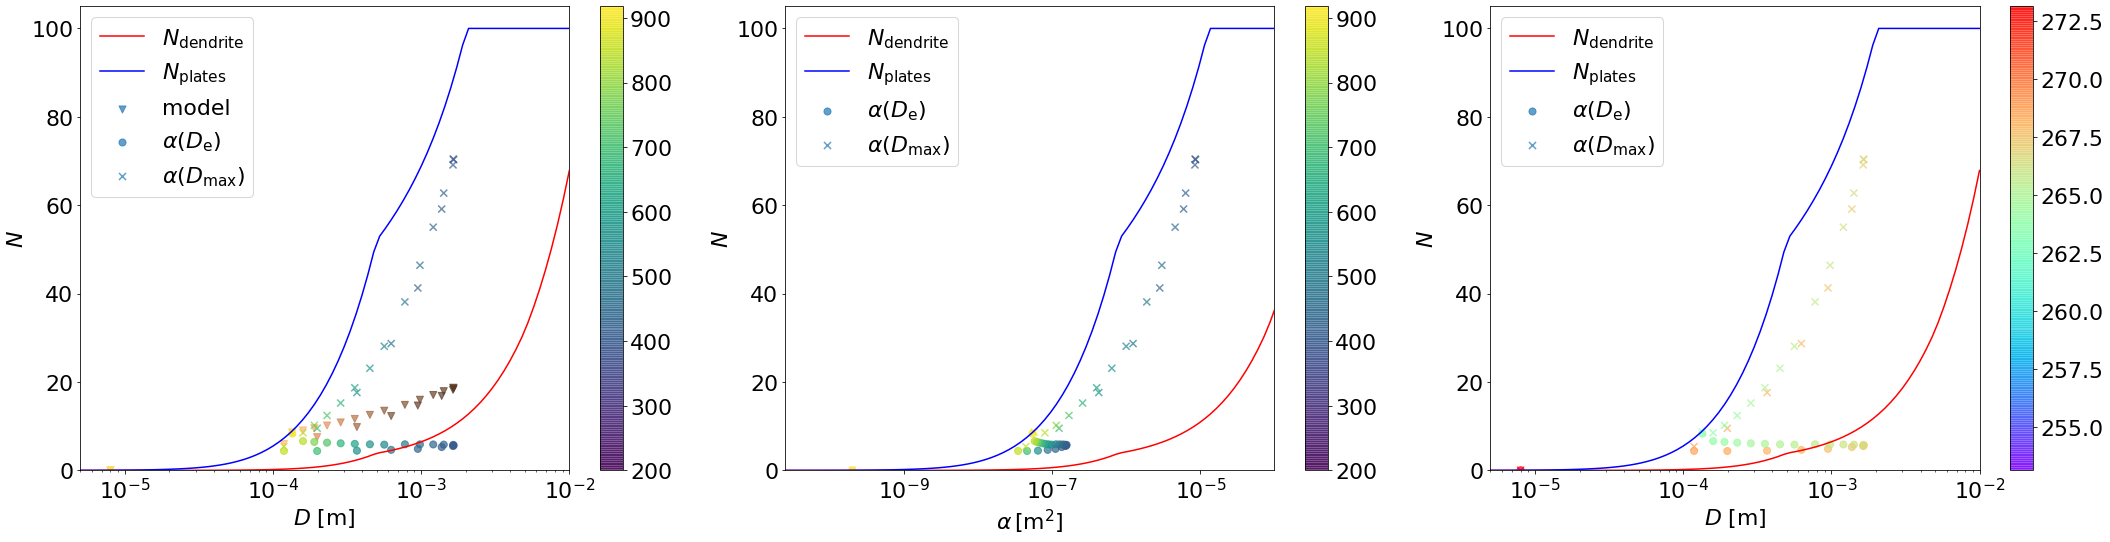

In [93]:
nrow2 = 1
ncol2 = 3
fig, ax = plt.subplots(nrows=nrow2, ncols=ncol2, figsize=[ncol2*10,nrow2*8])
ax1 = plt.subplot(nrow2, ncol2, 1)
ax1.plot(D_small, np.clip(N_fragments_den,None,100), c='red', label=leglabels[3])
ax1.plot(D_small, np.clip(N_fragments_pla,None,100), c='blue', label=leglabels[4])
#ax1.plot(D_small, np.clip(N_fragments_tot,None,100), c='green', label=leglabels[2])
#ax1.plot(D_small, np.clip(N_fragments_tot2,None,100), c='green', linestyle='--')

# mask to only show oblate particles
mask_N = np.ma.masked_where(tab1['phi']<1., N_fragments_proto)
mask_N2 = np.ma.masked_where(tab1['phi']<1., N_fragments_proto2)
mask_N3 = np.ma.masked_where(tab1['phi']<1., N_fragments_proto_norm)
plt.scatter(D_max, np.clip(mask_N3,None,100), c=rho_app_proto, cmap='copper',marker='v', alpha=.7, norm=col.Normalize(vmin=rho_min, vmax=rhoi), s=s, label='model')
plt.scatter(D_max, np.clip(mask_N,None,100), c=rho_app_proto, cmap='viridis', alpha=.7, norm=col.Normalize(vmin=rho_min, vmax=rhoi), s=s, label='$\\alpha(D_\mathrm{e})$')
plt.scatter(D_max, np.clip(mask_N2,None,100), c=rho_app_proto, cmap='viridis',marker='x', alpha=.7, norm=col.Normalize(vmin=rho_min, vmax=rhoi), s=s, label='$\\alpha(D_\mathrm{max})$')

plt.xscale('log')
plt.xlim(low_limit,up_limit)
plt.ylim(0,N_max)
plt.xlabel(alabels[0])
plt.ylabel(alabels[4])
plt.legend()
cbar=plt.colorbar()

#--------------------------------------------------------------------------------------------------
# plot 2:  N as function of alpha
ax1 = plt.subplot(nrow2, ncol2, 2)
ax1.plot(alpha, np.clip(N_fragments_den,None,100), c='red', label=leglabels[3])
ax1.plot(alpha, np.clip(N_fragments_pla,None,100), c='blue', label=leglabels[4])
#ax1.plot(D_small, np.clip(N_fragments_tot,None,100), c='green', label=leglabels[2])
#ax1.plot(D_small, np.clip(N_fragments_tot2,None,100), c='green', linestyle='--')

# mask to only show oblate particles
mask_N = np.ma.masked_where(tab1['phi']<1., N_fragments_proto)
mask_N2 = np.ma.masked_where(tab1['phi']<1., N_fragments_proto2)
mask_N3 = np.ma.masked_where(tab1['phi']<1., N_fragments_proto_norm)
plt.scatter(alpha_proto, np.clip(mask_N,None,100), c=rho_app_proto, cmap='viridis', alpha=.7, norm=col.Normalize(vmin=rho_min, vmax=rhoi), s=s, label='$\\alpha(D_\mathrm{e})$')
plt.scatter(alpha_proto2, np.clip(mask_N2,None,100), c=rho_app_proto, cmap='viridis',marker='x', alpha=.7, norm=col.Normalize(vmin=rho_min, vmax=rhoi), s=s, label='$\\alpha(D_\mathrm{max})$')

plt.xscale('log')
plt.xlim(low_limit**2,up_limit**2)
plt.ylim(0,N_max)
plt.xlabel('$\\alpha \, [\mathrm{m}^2]$' )
plt.ylabel(alabels[4])
plt.legend()
cbar=plt.colorbar()

#--------------------------------------------------------------------------------------------------
# plot 3: T dep.
ax2 = plt.subplot(nrow2, ncol2, 3)
ax2.plot(D_small, np.clip(N_fragments_den,None,100), c='red', label=leglabels[3])
ax2.plot(D_small, np.clip(N_fragments_pla,None,100), c='blue', label=leglabels[4])
#ax2.plot(D_small, np.clip(N_fragments_tot,None,100), c='green', label=leglabels[2])
#ax2.plot(D_small, np.clip(N_fragments_tot2,None,100), c='green', linestyle='--')

# mask to only show oblate particles
mask_N = np.ma.masked_where(tab1['phi']<1., N_fragments_proto)
plt.scatter(D_max, np.clip(mask_N,None,100), c=tab1['T'], cmap=cm, alpha=.7, norm=col.Normalize(vmin=253.15, vmax=273.15), s=s, label='$\\alpha(D_\mathrm{e})$')
plt.scatter(D_max, np.clip(mask_N2,None,100), c=tab1['T'], cmap=cm, marker='x', alpha=.7, norm=col.Normalize(vmin=253.15, vmax=273.15), s=s, label='$\\alpha(D_\mathrm{max})$')

plt.xscale('log')
plt.xlim(low_limit,up_limit)
plt.ylim(0,N_max)
plt.xlabel(alabels[0])
plt.ylabel(alabels[4])
plt.legend()

cbar=plt.colorbar()
fig.tight_layout()



pp.savefig(fig)

In [94]:
CKEs = np.logspace(-4,0,5)
N_cke_den = np.zeros([len(CKEs),len(D_small)])
N_cke_pla = np.zeros([len(CKEs),len(D_small)])
for idx,cke in enumerate(CKEs):
    N_cke_den[idx]= N_frag(alpha, A_den, B_den, cke, gamma_snow) 
    N_cke_pla[idx]= N_frag(alpha, A_pla, B_pla, cke, gamma_snow)


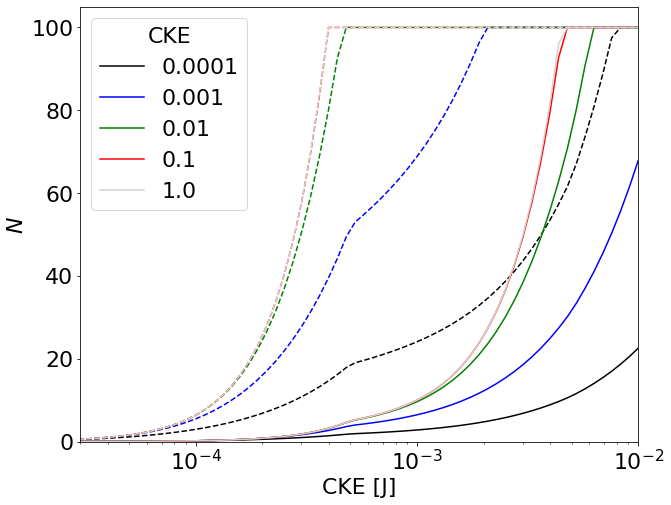

In [95]:
fig, ax = plt.subplots(figsize=[10,8])
c = ['black', 'blue', 'green', 'red', 'lightgray']
for j in range(len(CKEs)):
    ax = plt.plot(D_small, np.clip(N_cke_den[j],None,100), c=c[j], label=str(CKEs[j]))
    ax = plt.plot(D_small, np.clip(N_cke_pla[j],None,100), c=c[j], linestyle='--')

plt.xscale('log')
plt.xlim(3e-5,1e-2)
plt.ylim(0,1.05e2)
plt.xlabel('CKE [J]')
plt.ylabel(alabels[4])
plt.legend(title = "CKE")

In [96]:
pp.close()